# Laboratory 2 homework

 

First let's download the data which we will use for analysis

In [ ]:
%%bash

# Download:
# ---------
# - inter-station distances in 2022
wget https://opendata.rijdendetreinen.nl/public/tariff-distances/tariff-distances-2022-01.csv -O data/tariff-distances-2022-01.csv

# - railway stations in 2023
wget https://opendata.rijdendetreinen.nl/public/stations/stations-2023-09.csv -O data/stations-2023-09.csv

# - train disruptions between 2011 and 2023
for year in {2011..2023}
do
  wget https://opendata.rijdendetreinen.nl/public/disruptions/disruptions-${year}.csv -O data/disruptions-${year}.csv
done

# - train services between 2019 and 2025
for year in {2019..2024}
do
  wget https://opendata.rijdendetreinen.nl/public/services/services-${year}.csv.gz -O data/services-${year}.csv.gz
  gzip -d data/services-${year}.csv.gz
done

wget https://opendata.rijdendetreinen.nl/public/services/services-2025-09.csv.gz -O data/services-2025.csv.gz
gzip -d data/services-2025.csv.gz


In [1]:
import duckdb

db = duckdb.connect("data/duckdb_trains.db")

Put stations data into `stations` table in DuckDB. This changes rarely, so we
treat it as a almost constant file.

In [2]:
db.sql(
    """
CREATE TABLE IF NOT EXISTS stations AS
FROM "data/stations-2023-09.csv"
"""
)

Based on [DuckDB
tutorial](https://duckdb.org/2024/05/31/analyzing-railway-traffic-in-the-netherlands.html#largest-distance-between-train-stations-in-the-netherlands),
create tables `distances` and `distances_long`. We treat this similarly to
`stations` table.

In [3]:
db.sql(
    """
CREATE TABLE IF NOT EXISTS distances AS
FROM read_csv('data/tariff-distances-2022-01.csv', nullstr = 'XXX');
"""
)

db.sql(
    """
SELECT #1, #2, #3, #4, #5, #6, #7, #8, #9
FROM distances
LIMIT 8;
"""
)

┌─────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Station │  AC   │  AH   │  AHP  │ AHPR  │  AHZ  │  AKL  │  AKM  │  ALM  │
│ varchar │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │
├─────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ AC      │  NULL │    82 │    83 │    85 │    90 │    71 │   188 │    32 │
│ AH      │    82 │  NULL │     1 │     3 │     8 │    77 │   153 │    98 │
│ AHP     │    83 │     1 │  NULL │     2 │     9 │    78 │   152 │    99 │
│ AHPR    │    85 │     3 │     2 │  NULL │    11 │    80 │   150 │   101 │
│ AHZ     │    90 │     8 │     9 │    11 │  NULL │    69 │   161 │   106 │
│ AKL     │    71 │    77 │    78 │    80 │    69 │  NULL │   211 │    96 │
│ AKM     │   188 │   153 │   152 │   150 │   161 │   211 │  NULL │   158 │
│ ALM     │    32 │    98 │    99 │   101 │   106 │    96 │   158 │  NULL │
└─────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘

In [4]:
db.sql(
    """
CREATE TABLE IF NOT EXISTS distances_long AS
UNPIVOT distances
ON COLUMNS (* EXCLUDE station)
INTO NAME other_station VALUE distance;
"""
)

db.sql("""
SELECT station, other_station, distance
FROM distances_long
LIMIT 3;
""")

┌─────────┬───────────────┬──────────┐
│ Station │ other_station │ distance │
│ varchar │    varchar    │  int64   │
├─────────┼───────────────┼──────────┤
│ AC      │ AH            │       82 │
│ AC      │ AHP           │       83 │
│ AC      │ AHPR          │       85 │
└─────────┴───────────────┴──────────┘

Put train disruptions into `disruptions` table in the Postgres database. We
expect this data to change regularly, and thus treat it as a typical OLTP table.

In [5]:
import os
from dotenv import load_dotenv

load_dotenv(".env")
DB_USER = os.environ.get("DB_USER")
DB_PASSWD = os.environ.get("DB_PASSWD")
conn_string = f"host=localhost user={DB_USER} password={DB_PASSWD} dbname=postgres"

db.sql(f"""ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db (TYPE postgres);""")
db.sql(
    f"""
CREATE TABLE IF NOT EXISTS postgres_db.disruptions AS
FROM read_csv({[f"data/disruptions-{year}.csv" for year in range(2011, 2024)]})
"""
)
db.sql("DESCRIBE postgres_db.disruptions")

┌──────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name      │ column_type │  null   │   key   │ default │  extra  │
│       varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ rdt_id               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ ns_lines             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines_id         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_names    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_codes    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_nl             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_en             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ statistical_cause_nl │ VARCHAR     │ YES     │ NUL

Transform train services CSV files into a single Parquet file. Make table
`services` from it. We treat this as a big data batch input, created rarely but
regularly for analytics purposes.

In [6]:
duckdb.sql(
    f"""
COPY (SELECT * FROM read_csv({[f"data/services-{year}.csv" for year in range(2019, 2026)]}))
TO "data/services_duckdb.parquet" (FORMAT "PARQUET", COMPRESSION "ZSTD")
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
db.sql("""
CREATE TABLE IF NOT EXISTS services AS
FROM "data/services_duckdb.parquet"
""")

In all following questions, use tables `services`, `distances_long`,
`disruptions` and `stations` as necessary. Remember that each row represents
single ride between stations, while the whole end-to-end train service has the
same value in `Service:RDT-ID` column. Note that starting station for a service
has NULL value in `Stop:Arrival time` column, while the end station has NULL
value in `Stop:Departure time` column.

In [8]:
db.sql("""SHOW ALL TABLES""")

┌───────────────┬─────────┬────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Make queries to answer the following questions:

How many trains departed from Amsterdam Central station overall?

In [131]:
db.sql(
    """
SELECT COUNT(DISTINCT "Service:RDT-ID")
FROM services
WHERE 
    "Stop:Station name" = 'Amsterdam Centraal' 
    AND "Stop:Departure time" IS NOT NULL
"""
)

┌──────────────────────────────────┐
│ count(DISTINCT "Service:RDT-ID") │
│              int64               │
├──────────────────────────────────┤
│                          1691359 │
└──────────────────────────────────┘

Calculate the average arrival delay of different service types (`Service:Type`).
Order results descending by average delay.

In [10]:
db.sql(
    """
SELECT 
    "Service:Type", 
    AVG(COALESCE("Stop:Arrival delay", 0)) AS 'Average arrival delay'
FROM services
GROUP BY "Service:Type"
ORDER BY 2 DESC
"""
)

┌────────────────────┬───────────────────────┐
│    Service:Type    │ Average arrival delay │
│      varchar       │        double         │
├────────────────────┼───────────────────────┤
│ Alpen Express      │    21.956190476190475 │
│ Krokus Express     │    11.378378378378379 │
│ European Sleeper   │     9.562580437580438 │
│ Nightjet           │     7.752348244687097 │
│ Eurostar           │     5.252845831241802 │
│ ICE International  │      4.67575713240673 │
│ Thalys             │     4.366045308646701 │
│ Int. Trein         │    3.9175789802940257 │
│ Nachttrein         │     3.657340458975165 │
│ Stoomtrein         │     2.285140562248996 │
│     ·              │                    ·  │
│     ·              │                    ·  │
│     ·              │                    ·  │
│ Metro i.p.v. trein │                   0.0 │
│ Niet instappen     │                   0.0 │
│ Taxibus ipv trein  │                   0.0 │
│ stoptrein          │                   0.0 │
│ Belbus     

What was the most common disruption cause in different years? [MODE
function](https://duckdb.org/docs/stable/sql/functions/aggregates.html#modex)
may be useful.

In [32]:
db.sql(
    """
SELECT
    MODE("cause_en"),
    EXTRACT(YEAR FROM "start_time") AS year,
FROM postgres_db.disruptions
GROUP BY year
ORDER BY year
"""
)

┌───────────────────┬───────┐
│ "mode"(cause_en)  │ year  │
│      varchar      │ int64 │
├───────────────────┼───────┤
│ broken down train │  2011 │
│ points failure    │  2012 │
│ points failure    │  2013 │
│ broken down train │  2014 │
│ broken down train │  2015 │
│ broken down train │  2016 │
│ broken down train │  2017 │
│ broken down train │  2018 │
│ broken down train │  2019 │
│ broken down train │  2020 │
│ broken down train │  2021 │
│ broken down train │  2022 │
│ broken down train │  2023 │
├───────────────────┴───────┤
│ 13 rows         2 columns │
└───────────────────────────┘

How many trains started their overall service in any Amsterdam station?

In [176]:
db.sql(
    """
SELECT COUNT(DISTINCT "Service:RDT-ID")
FROM services
WHERE 
    "Stop:Arrival time" IS NULL
    AND "Stop:Station name" LIKE 'Amsterdam%'
"""
)

┌──────────────────────────────────┐
│ count(DISTINCT "Service:RDT-ID") │
│              int64               │
├──────────────────────────────────┤
│                          1098189 │
└──────────────────────────────────┘

What fraction of services was run to final destinations outside the Netherlands?

In [189]:
db.sql(
    """
SELECT 
    COUNT(DISTINCT "Service:RDT-ID") / 
    (SELECT COUNT(DISTINCT "Service:RDT-ID") FROM services WHERE "Stop:Departure time" IS NULL) 
    AS abroad_fraction
FROM services
JOIN stations ON services."Stop:Station code" = stations.code
WHERE services."Stop:Departure time" IS NULL AND stations.country != 'NL'
"""
)

┌──────────────────────┐
│   abroad_fraction    │
│        double        │
├──────────────────────┤
│ 0.036795696821134864 │
└──────────────────────┘

What is the largest distance between stations in the Netherlands (code `NL`)?

In [269]:
db.sql(
    """
SELECT
    s1.name_long AS station1,
    s2.name_long AS station2,
    distances_long.distance
FROM distances_long
JOIN stations s1 ON distances_long.station = s1.code
JOIN stations s2 ON distances_long.other_station = s2.code
WHERE s1.country = 'NL'
  AND s2.country = 'NL'
  AND station < other_station
ORDER BY distance DESC
LIMIT 1;
"""
)

┌───────────┬────────────┬──────────┐
│ station1  │  station2  │ distance │
│  varchar  │  varchar   │  int64   │
├───────────┼────────────┼──────────┤
│ Eemshaven │ Vlissingen │      426 │
└───────────┴────────────┴──────────┘

Compare the average arrival delay between different train operators
(`Service:Company`) on a bar plot. Sort them appropriately.

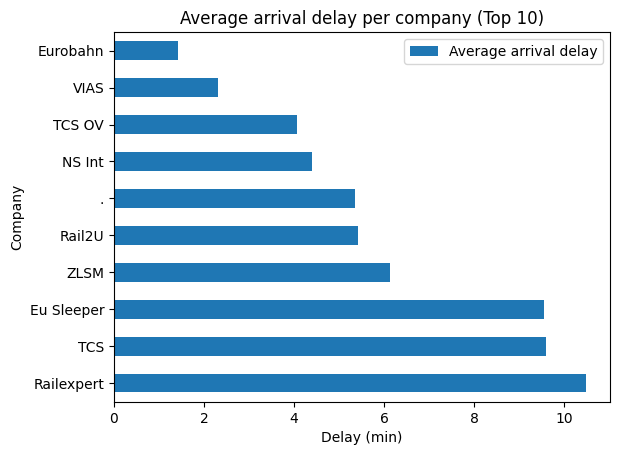

In [ ]:
df_dealys_per_company = db.sql(
    """
SELECT 
    "Service:Company" AS "Company",
    AVG(COALESCE("Stop:Arrival delay", 0)) AS "Average arrival delay"
FROM services
GROUP BY "Service:Company"
ORDER BY 2 DESC
"""
).df()

df_dealys_per_company.head(10).plot.barh(
    x="Company",
    y="Average arrival delay",
    xlabel="Delay (min)",
    title="Average arrival delay per company (Top 10)",
);

How many services were disrupted in different years? Make a line plot.

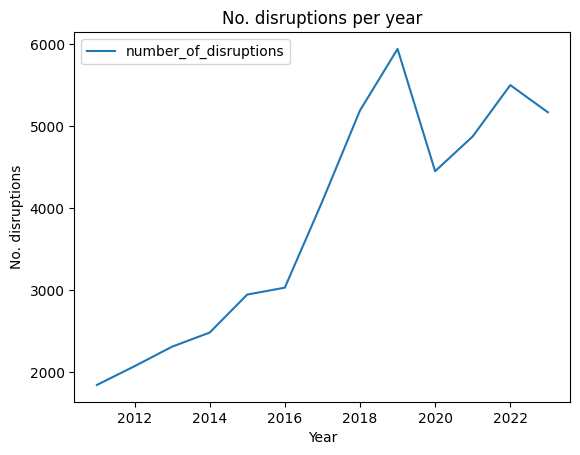

In [236]:
df_disruptions_per_year = db.sql(
    """
SELECT
    EXTRACT(YEAR FROM "start_time") AS year,
    COUNT(*) as number_of_disruptions
FROM postgres_db.public.disruptions
GROUP BY year
ORDER BY year;
"""
).df()

df_disruptions_per_year.plot.line(
    x="year",
    y="number_of_disruptions",
    xlabel="Year",
    ylabel="No. disruptions",
    title="No. disruptions per year",
);

What fraction of all services were cancelled (`Service:Completely cancelled`) in
different years? Make a line plot.

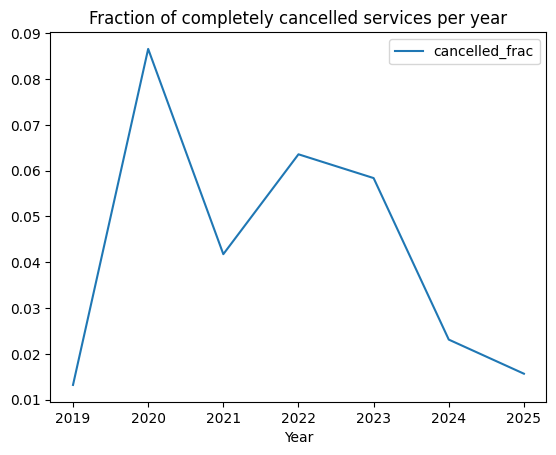

In [235]:
df_cancelled_frac = db.sql(
    """
WITH cancelled_services AS (       
SELECT 
    "Service:RDT-ID", 
    MAX("Service:Completely cancelled") AS service_cancelled,
    EXTRACT(YEAR FROM "Service:Date") AS year
FROM services
GROUP BY "Service:RDT-ID", year
ORDER BY year DESC
)

SELECT year, SUM(service_cancelled) / COUNT(*) AS cancelled_frac
FROM cancelled_services
GROUP BY year
"""
).df()

df_cancelled_frac.plot.line(
    x="year",
    y="cancelled_frac",
    xlabel="Year",
    title="Fraction of completely cancelled services per year",
);

Currently, `services` table does not provide information about service lengths,
neither between pairs of stations nor for the end-to-end service. Prepare this
information:

1. Note that each service has the same `Service:RDT-ID`, and stations can be
    ordered by `Stop:Departure time`, with the last one being NULL. Using
    [window
    functions](https://duckdb.org/docs/stable/sql/functions/window_functions.html),
    specifically [LAG() or
    LEAD()](https://duckdb.org/docs/stable/sql/functions/window_functions.html),
    you can get next row. [This
    example](https://stackoverflow.com/a/62584847/9472066) may also be useful.
2. Create table `station_connections`, with columns `Service:RDT-ID`,
    `start_station_code` and `end_station_code` (pair of stations on a route),
    and `distance` between them. Note that you should deduplicate the data on
    station codes, so that every station pair appears only once. Create
    temporary tables, use a subquery, or any other similar techniques if
    necessary.
3. What is the largest distance between a pair of stations?
4. Plot a histogram of inter-station distances run by trains.

In [ ]:
db.sql(
    """
CREATE TABLE IF NOT EXISTS station_connections AS (

    WITH service_routes AS (
    SELECT 
        "Service:RDT-ID",
        "Stop:Station code" as start_station_code,
        LEAD("Stop:Station code", 1) OVER (
            PARTITION BY "Service:RDT-ID" 
            ORDER BY "Stop:Departure time") AS end_station_code,
    FROM services
    )

    SELECT "Service:RDT-ID", start_station_code, end_station_code, distance 
    FROM service_routes AS sr
    LEFT JOIN distances_long AS dl
        ON sr.start_station_code = dl.Station
        AND sr.end_station_code = dl.other_station
    WHERE end_station_code IS NOT NULL
)
"""
)

In [265]:
db.sql("""SELECT * FROM station_connections""")

┌────────────────┬────────────────────┬──────────────────┬──────────┐
│ Service:RDT-ID │ start_station_code │ end_station_code │ distance │
│     int64      │      varchar       │     varchar      │  int64   │
├────────────────┼────────────────────┼──────────────────┼──────────┤
│       16862842 │ DTCH               │ WL               │        3 │
│       16862842 │ WL                 │ DID              │        6 │
│       16862842 │ DID                │ ZV               │        5 │
│       16862842 │ ZV                 │ DVN              │        5 │
│       16862842 │ DVN                │ WTV              │        4 │
│       16862842 │ WTV                │ AHP              │        4 │
│       16862842 │ AHP                │ AH               │        1 │
│       16863179 │ ASDZ               │ ASD              │       12 │
│       16863682 │ HT                 │ ZBM              │       13 │
│       16863682 │ ZBM                │ GDM              │        9 │
│           ·    │  

In [ ]:
db.sql(
    """
SELECT *
FROM station_connections
ORDER BY distance DESC
LIMIT 1
"""
)

┌────────────────┬────────────────────┬──────────────────┬──────────┐
│ Service:RDT-ID │ start_station_code │ end_station_code │ distance │
│     int64      │      varchar       │     varchar      │  int64   │
├────────────────┼────────────────────┼──────────────────┼──────────┤
│        7124817 │ VS                 │ STV              │      421 │
└────────────────┴────────────────────┴──────────────────┴──────────┘

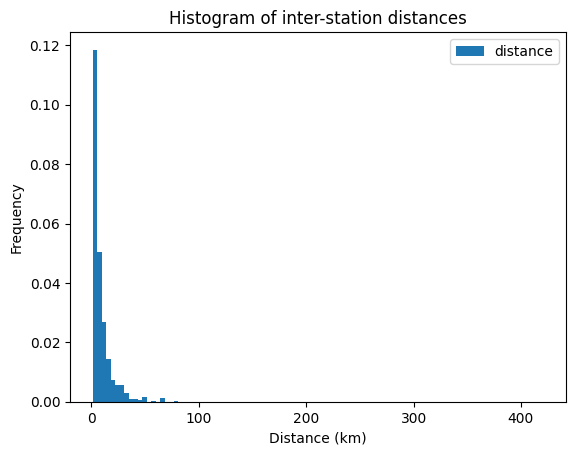

In [277]:
df_distances = db.sql("""SELECT distance FROM station_connections""").df()
df_distances.plot.hist(
    bins=100,
    density=True,
    xlabel="Distance (km)",
    title="Histogram of inter-station distances",
);